In [37]:
import pandas as pd
pd.set_option("mode.copy_on_write", True)
import geopandas as gpd
import fiona
import os
import matplotlib.pyplot as plt


In [38]:
######################################################################
# LOAD FIRE DATA LOCATION
######################################################################
# Step 1: Load FRAP Perimeter Data: https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters (see dictionnary)

# Path to the `.gdb` folder (NOT a file inside it)
fire_path = "../00_Downloaded_Data/fire_data.gdb" # download and store it

# List all available layers in the geodatabase
layers = fiona.listlayers(fire_path)
print(layers)  # You'll see something like ['firep20_1', 'rxburn21', etc.]

# Load one of the layers (try first layer if unsure)
fire_data = gpd.read_file(fire_path, layer=layers[0])

# Clean for the merge: remove extra space
fire_data["FIRE_NAME_CLEAN"] = fire_data["FIRE_NAME"].str.upper().str.strip()
fire_data = fire_data.drop(columns=["FIRE_NAME"]) # drop original column to avoid confusion

# View first few rows
fire_data.head(4)

['firep23_1', 'rxburn23_1']


,YEAR_,STATE,AGENCY,UNIT_ID,INC_NUM,IRWINID,ALARM_DATE,CONT_DATE,C_METHOD,CAUSE,OBJECTIVE,GIS_ACRES,COMPLEX_NAME,COMPLEX_ID,COMMENTS,FIRE_NUM,Shape_Length,Shape_Area,geometry,FIRE_NAME_CLEAN
0,2023.0,CA,CDF,SKU,00004808,{7985848C-0AC2-4BA4-8F0E-29F778652E61},2023/06/17 00:00:00+00,2023/06/17 00:00:00+00,1.0,5.0,1.0,5.729125,None,None,None,None,933.907127,23184.946763,"MULTIPOLYGON (((-243242.555 394267.371, -24324...",WHITWORTH
1,2023.0,CA,LRA,BTU,00010225,{43EBCC88-B3AC-48EB-8EF5-417FE0939CCF},2023/06/02 00:00:00+00,2023/06/02 00:00:00+00,1.0,5.0,1.0,13.602385,None,None,None,None,986.343353,55046.898792,"MULTIPOLYGON (((-167826.147 203275.612, -16782...",KAISER
2,2023.0,CA,CDF,AEU,00017640,{B64E1355-BF1D-441A-95D0-BC1FBB93483B},2023/07/01 00:00:00+00,2023/07/02 00:00:00+00,1.0,2.0,1.0,27.814465,None,None,None,None,2115.572740,112561.147688,"MULTIPOLYGON (((-79176.443 31393.49, -78959.04...",JACKSON
3,2023.0,CA,CDF,AEU,00018821,{CB41DB0A-E4B1-489D-A4EA-738F2CD6DB3B},2023/07/11 00:00:00+00,2023/07/11 00:00:00+00,1.0,9.0,1.0,58.760227,None,None,None,None,1994.866526,237794.210367,"MULTIPOLYGON (((-85936.934 47921.886, -85856.4...",CARBON


In [39]:
######################################################################
# FILTER BOTH DATASETS FROM 2012-2023
######################################################################

# Step 3: Filter both dataset to only take data from 2012 to 2023
# Do this cause one the years do not match

# Define year range
min_year = 2012
max_year = 2023

# Filter both datasets
fire_data = fire_data[
    fire_data["YEAR_"].between(min_year, max_year)
]

#fire_data["YEAR_"].value_counts()

In [40]:
fire_data.isna().sum()

YEAR_                 0
STATE                 0
AGENCY                5
UNIT_ID              16
INC_NUM              39
IRWINID            1093
ALARM_DATE           17
CONT_DATE            59
C_METHOD              9
CAUSE                 0
OBJECTIVE           101
GIS_ACRES             0
COMPLEX_NAME       4160
COMPLEX_ID         4259
COMMENTS           1968
FIRE_NUM           4066
Shape_Length          0
Shape_Area            0
geometry              0
FIRE_NAME_CLEAN      11
dtype: int64

In [41]:
fire_data.shape

(4389, 20)

In [42]:
######################################################################
# LOAD CENSUS TRACTS SHAPEFILE: GIVES EXACT LOACTION AND SURFACE AREA
######################################################################

# Step 1: Load Census Track Shapefile

# Path to the folder containing the shapefile components
shapefile_path_2013 = "../00_Downloaded_Data/census_tracts_shapefile_2013/tl_2013_06_tract.shp"
shapefile_path_2020 = "../00_Downloaded_Data/census_tracts_shapefile_2020/tl_2020_06_tract.shp"
# Load the shapefile as a GeoDataFrame

shapefile_2013 = gpd.read_file(shapefile_path_2013)
shapefile_2020 = gpd.read_file(shapefile_path_2020)



In [43]:
shapefile_2020.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,029,004402,06029004402,44.02,Census Tract 44.02,G5020,S,1865739,0,+35.5917343,-119.3337642,"POLYGON ((-119.33828 35.58143, -119.33827 35.5..."
1,06,047,000802,06047000802,8.02,Census Tract 8.02,G5020,S,2321653,0,+37.3433591,-120.5854604,"POLYGON ((-120.59599 37.34121, -120.59596 37.3..."
2,06,085,501402,06085501402,5014.02,Census Tract 5014.02,G5020,S,522620,0,+37.3453341,-121.8665169,"POLYGON ((-121.87381 37.34412, -121.87361 37.3..."
3,06,005,000102,06005000102,1.02,Census Tract 1.02,G5020,S,456204155,7940832,+38.5496993,-120.2509786,"POLYGON ((-120.61016 38.4156, -120.61 38.41577..."
4,06,029,004901,06029004901,49.01,Census Tract 49.01,G5020,S,1459379,0,+35.7837173,-119.2462266,"POLYGON ((-119.25262 35.79043, -119.25259 35.7..."


In [44]:
#######################################################################
# CHECK IF TRACTS CENSUS MATCH IN BOTH DATASETS
######################################################################

# Track census tracts changes every year: they are merged or even divided over the years so some old track census might no longer exists while new ones are created

# Step 1. Get the list of unique GEO IDs for each time range

geo_2013 = set(shapefile_2013["COUNTYFP"] + shapefile_2013["TRACTCE"])
geo_2020 = set(shapefile_2020["COUNTYFP"] + shapefile_2020["TRACTCE"])


# Step 2. Compare
print(f"2013 unique tracts: {len(geo_2013)}")
print(f"2023 unique tracts: {len(geo_2020)}")

# Step 3. Find missing tracts (if any)
missing_in_2020 = geo_2013 - geo_2020
missing_in_2013 = geo_2020 - geo_2013

print(f"Tracts missing in 2020-2023 but present in 2012-2019: {len(missing_in_2020)}")
print(f"Tracts missing in 2012-2019 but present in 2020-2023: {len(missing_in_2013)}")



2013 unique tracts: 8057
2023 unique tracts: 9129
Tracts missing in 2020-2023 but present in 2012-2019: 1176
Tracts missing in 2012-2019 but present in 2020-2023: 2248


In [45]:
#######################################################################
# KEEP COMMON CENCUS TRACTS 
######################################################################

# Find common GEO IDs
common_geo_ids = geo_2013.intersection(geo_2020)

# Create a final shapefile (only 2020 census tracts that exist in both 2013 and 2020)
final_census_shapefile = shapefile_2020[
    (shapefile_2020["COUNTYFP"] + shapefile_2020["TRACTCE"]).isin(common_geo_ids)
].copy()

# Create a single GEOID column for easier merging later
final_census_shapefile["GEO_UNIQUE_ID"] = final_census_shapefile["COUNTYFP"] + final_census_shapefile["TRACTCE"]

# Transform Geometry in meters, will no longer be in degrees so area calculation will be correct
final_census_shapefile = final_census_shapefile.to_crs(epsg=3310)
 
# Copy the full track census geometry so it won't be lost when overlaying
#final_census_shapefile["GEOMETRY_TRACT_CENSUS"] = final_census_shapefile["geometry"].copy()




# Preview
final_census_shapefile.shape
final_census_shapefile.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,GEO_UNIQUE_ID
0,06,029,004402,06029004402,44.02,Census Tract 44.02,G5020,S,1865739,0,+35.5917343,-119.3337642,"POLYGON ((59906.842 -270407.558, 59906.948 -27...",029004402
1,06,047,000802,06047000802,8.02,Census Tract 8.02,G5020,S,2321653,0,+37.3433591,-120.5854604,"POLYGON ((-52727.332 -74888.681, -52723.908 -7...",047000802
2,06,085,501402,06085501402,5014.02,Census Tract 5014.02,G5020,S,522620,0,+37.3453341,-121.8665169,"POLYGON ((-165759.786 -73091.934, -165741.347 ...",085501402
3,06,005,000102,06005000102,1.02,Census Tract 1.02,G5020,S,456204155,7940832,+38.5496993,-120.2509786,"POLYGON ((-53212.46 44552.019, -53197.688 4457...",005000102
4,06,029,004901,06029004901,49.01,Census Tract 49.01,G5020,S,1459379,0,+35.7837173,-119.2462266,"POLYGON ((67478.588 -247133.459, 67482.018 -24...",029004901


In [46]:
final_census_shapefile.shape

(6881, 14)

In [47]:
######################################################################
# PERFORM SPATIAL JOIN ON FIRE DATA AND SHAPEFILE CENSUS TRACTS
######################################################################

''' We performe a spatial join to link each fire incident to a census tracts region,
using their geometries. This allows us to analyze the impact of wildfires by tracts.'''

# Make sure both GeoDataFrames use the same CRS
# CRS tells your GeoDataFrame how to interpret the geometry numbers
fire_data = fire_data.to_crs(final_census_shapefile.crs)

# Transform Geometry in meters, will no longer be in degrees so area calculation will be correct
fire_data = fire_data.to_crs(epsg=3310)  # California Albers

# Spatial join: attach ZIP info to each fire based on location
#fires_with_zip = gpd.sjoin(merged_fire_data,final_census_shapefile, how="left", predicate="intersects")
# overlay = cutting fires: "this piece of fire inside tract 1234, and another piece inside 5678"
fires_with_tracts_data = gpd.overlay(fire_data, final_census_shapefile, how="intersection")

# Now you can see which parts of fires intersected which tracts
fires_with_tracts_data.tail(2)
# Preview result
#fires_with_zip[["FIRE_NAME_CLEAN", "YEAR_", "ZIP_CODE", "PO_NAME", "geometry"]].head()



,YEAR_,STATE,AGENCY,UNIT_ID,INC_NUM,IRWINID,ALARM_DATE,CONT_DATE,C_METHOD,CAUSE,...,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,GEO_UNIQUE_ID,geometry
3584,2012.0,CA,NPS,LNP,00003115,None,2012/07/23 00:00:00+00,2012/11/13 00:00:00+00,8.0,14.0,...,126.03,Census Tract 126.03,G5020,S,801330280,4583285,+40.4806114,-121.7401412,089012603,"POLYGON ((-115691.313 286277.023, -115689.457 ..."
3585,2012.0,CA,NPS,YNP,00001473,None,2012/06/16 00:00:00+00,2012/11/09 00:00:00+00,2.0,1.0,...,4,Census Tract 4,G5020,S,1019187011,4453736,+37.6979738,-119.5740176,043000400,"POLYGON ((27203.135 -27152.562, 27203.9 -27151..."


In [48]:
fires_with_tracts_data.shape

(3586, 33)

In [49]:
fires_with_tracts_data.columns

Index(['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'INC_NUM', 'IRWINID',
       'ALARM_DATE', 'CONT_DATE', 'C_METHOD', 'CAUSE', 'OBJECTIVE',
       'GIS_ACRES', 'COMPLEX_NAME', 'COMPLEX_ID', 'COMMENTS', 'FIRE_NUM',
       'Shape_Length', 'Shape_Area', 'FIRE_NAME_CLEAN', 'STATEFP', 'COUNTYFP',
       'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'GEO_UNIQUE_ID', 'geometry'],
      dtype='object')

In [50]:
######################################################################
# CLEAN: DROP COLUMNS + RENAME COLUMNS 
######################################################################

columns_to_keep = [
    "YEAR_",
    "FIRE_NAME_CLEAN",
    "GEO_UNIQUE_ID",
    "ALARM_DATE",
    "CONT_DATE",
    #"GIS_ACRES",
    #"COUNTYFP",
    #"TRACTCE",
    'ALAND', # 
    "geometry", # all surafce area of the fire ==> most important
    #"GEOMETRY_TRACT_CENSUS"
]

fires_with_tracts_data = fires_with_tracts_data[columns_to_keep]

# Rename confusing columns
fires_with_tracts_data = fires_with_tracts_data.rename(columns={
    'YEAR_': 'YEAR',
    #'GIS_ACRES': 'ACRES_BURNED', # Acres for FULL fire not for inside specific tract
    'ALAND': 'TRACT_AREA_M2',  # full size of the census tract: make it clear this is tract surface in m²
    'geometry': 'GEOMETRY_OF_FIRExTRACT' # surafec area of only the fire chunk inside that tract
})

fires_with_tracts_data.head(10)

,YEAR,FIRE_NAME_CLEAN,GEO_UNIQUE_ID,ALARM_DATE,CONT_DATE,TRACT_AREA_M2,GEOMETRY_OF_FIRExTRACT
0,2023.0,WHITWORTH,093000800,2023/06/17 00:00:00+00,2023/06/17 00:00:00+00,3204025612,"POLYGON ((-243244.697 394266.719, -243245.934 ..."
1,2023.0,KAISER,007001400,2023/06/02 00:00:00+00,2023/06/02 00:00:00+00,317313593,"POLYGON ((-167825.938 203269.795, -167833.483 ..."
2,2023.0,JACKSON,005000304,2023/07/01 00:00:00+00,2023/07/02 00:00:00+00,141704648,"POLYGON ((-78959.041 31561.489, -78947.331 315..."
3,2023.0,CARBON,005000301,2023/07/11 00:00:00+00,2023/07/11 00:00:00+00,195548070,"POLYGON ((-85856.474 47977.365, -85841.981 480..."
4,2023.0,LIBERTY,005000304,2023/07/11 00:00:00+00,2023/07/12 00:00:00+00,141704648,"POLYGON ((-86436.113 26420.918, -86457.63 2639..."
5,2023.0,CLAY,067009406,2023/06/18 00:00:00+00,2023/06/18 00:00:00+00,155014342,"POLYGON ((-93826.211 32831.81, -93895.323 3289..."
6,2023.0,PAICINES,069000802,2023/07/13 00:00:00+00,2023/07/13 00:00:00+00,2987639939,"POLYGON ((-114538.39 -140323.911, -114497.455 ..."
7,2023.0,VINEYARD,053011400,2023/07/09 00:00:00+00,2023/07/10 00:00:00+00,3667519241,"POLYGON ((-63488.777 -245455.819, -63484.162 -..."
8,2023.0,SLACKS,053011400,2023/07/15 00:00:00+00,2023/07/17 00:00:00+00,3667519241,"POLYGON ((-51441.409 -237982.21, -51447.675 -2..."
9,2023.0,IDRIA,069000802,2023/07/19 00:00:00+00,2023/07/19 00:00:00+00,2987639939,"POLYGON ((-71933.954 -171509.522, -71937.654 -..."


In [51]:
fires_with_tracts_data.shape

(3586, 7)

In [52]:
######################################################################
# FEATURE ENGINEERING: ADD AREA BURNED AND PERCENT OF AREA BURNED
######################################################################

# Calculate the acres burned in each tracts
fires_with_tracts_data["AREA_BURNED_IN_M2"] = fires_with_tracts_data["GEOMETRY_OF_FIRExTRACT"].area # Each tract will show how many acres in that tract only were burned
# .area: calculates the area of each polygon in your GeoDataFrame.

# Calculate the PCT of the surface area of a tract that was burned
# Calculate % burned using M²
fires_with_tracts_data["PCT_TRACT_BURNED"] = (
    fires_with_tracts_data["AREA_BURNED_IN_M2"] / fires_with_tracts_data["TRACT_AREA_M2"]
) * 100

# Drop misleading/useless columns now
fires_with_tracts_data = fires_with_tracts_data.drop(columns=["GEOMETRY_OF_FIRExTRACT"])

# Fix: 26 of it shows more than 100% of the area burned: cap it to 100%
# Issue comes from slight mismatch in geometry sometimes or overlapping

over_100_count = (fires_with_tracts_data["PCT_TRACT_BURNED"] > 100).sum() # Count how many tracts had >100% burned
fires_with_tracts_data["PCT_TRACT_BURNED"] = fires_with_tracts_data["PCT_TRACT_BURNED"].clip(upper=100) # cap to 100%

fires_with_tracts_data.tail()

,YEAR,FIRE_NAME_CLEAN,GEO_UNIQUE_ID,ALARM_DATE,CONT_DATE,TRACT_AREA_M2,AREA_BURNED_IN_M2,PCT_TRACT_BURNED
3581,2012.0,PASS,027000800,2012/08/10 00:00:00+00,2012/08/17 00:00:00+00,17743920238,1.783978e+06,0.010054
3582,2012.0,SOUTH,027000800,2012/08/10 00:00:00+00,2012/08/13 00:00:00+00,17743920238,3.512843e+04,0.000198
3583,2012.0,READING,089012702,2012/07/23 00:00:00+00,2012/11/13 00:00:00+00,1291882205,4.510598e+07,3.491494
3584,2012.0,READING,089012603,2012/07/23 00:00:00+00,2012/11/13 00:00:00+00,801330280,6.850224e+07,8.548565
3585,2012.0,CASCADE,043000400,2012/06/16 00:00:00+00,2012/11/09 00:00:00+00,1019187011,6.899590e+06,0.676970


In [53]:
######################################################################
# FEATURE ENGINEERING: DURATION OF BURN
######################################################################

# IMPORTANT: fire duration is measured at the fire level, not tract-specific

# Make sure dates are in datetime format
fires_with_tracts_data["ALARM_DATE"] = pd.to_datetime(fires_with_tracts_data["ALARM_DATE"], errors="coerce")
fires_with_tracts_data["CONT_DATE"] = pd.to_datetime(fires_with_tracts_data["CONT_DATE"], errors="coerce")

# Create fire duration in days
fires_with_tracts_data["FIRE_DURATION_DAYS"] = (fires_with_tracts_data["CONT_DATE"] - fires_with_tracts_data["ALARM_DATE"]).dt.days

# Remove negative durations (if any)
fires_with_tracts_data = fires_with_tracts_data[fires_with_tracts_data["FIRE_DURATION_DAYS"] > 0]

fires_with_tracts_data.tail()


,YEAR,FIRE_NAME_CLEAN,GEO_UNIQUE_ID,ALARM_DATE,CONT_DATE,TRACT_AREA_M2,AREA_BURNED_IN_M2,PCT_TRACT_BURNED,FIRE_DURATION_DAYS
3581,2012.0,PASS,027000800,2012-08-10 00:00:00+00:00,2012-08-17 00:00:00+00:00,17743920238,1.783978e+06,0.010054,7.0
3582,2012.0,SOUTH,027000800,2012-08-10 00:00:00+00:00,2012-08-13 00:00:00+00:00,17743920238,3.512843e+04,0.000198,3.0
3583,2012.0,READING,089012702,2012-07-23 00:00:00+00:00,2012-11-13 00:00:00+00:00,1291882205,4.510598e+07,3.491494,113.0
3584,2012.0,READING,089012603,2012-07-23 00:00:00+00:00,2012-11-13 00:00:00+00:00,801330280,6.850224e+07,8.548565,113.0
3585,2012.0,CASCADE,043000400,2012-06-16 00:00:00+00:00,2012-11-09 00:00:00+00:00,1019187011,6.899590e+06,0.676970,146.0


In [ ]:
######################################################################
# FINAL FIRE DATA: GROUP FIRE BY TRACT AND YEAR
######################################################################

# Group fire data by tract and year
final_fire_data = fires_with_tracts_data.groupby(["GEO_UNIQUE_ID", "YEAR"]).agg(
    
    # Count how many distinct fires touched this tract this year
    NUM_FIRES = ("FIRE_NAME_CLEAN", "nunique"),
    
    # Sum total area burned across all fires in this tract this year
    TOTAL_AREA_BURNED_IN_M2 = ("AREA_BURNED_IN_M2", "sum"),
    
    # Average fire duration (in days) for fires touching this tract this year
    AVG_FIRE_DURATION_DAYS = ("FIRE_DURATION_DAYS", "mean"),
    
    # Maximum % of the tract that burned in a single fire
    MAX_PCT_TRACT_BURNED = ("PCT_TRACT_BURNED", "max"),

    # Each census track is reprensneted by its same geometry across time
   # GEOMETRY_TRACT_CENSUS=('GEOMETRY_TRACT_CENSUS', 'first'), 
    
).reset_index()  # optional: resets GEO_UNIQUE_ID and YEAR to normal columns

final_fire_data.head()

,GEO_UNIQUE_ID,YEAR,NUM_FIRES,TOTAL_AREA_BURNED_IN_M2,AVG_FIRE_DURATION_DAYS,MAX_PCT_TRACT_BURNED
0,001435103,2020.0,1,3.043601e+01,26.0,0.000059
1,001450601,2020.0,1,8.339614e+04,26.0,0.166478
2,001450701,2020.0,1,4.692063e+07,26.0,17.805174
3,003010000,2012.0,1,5.875029e+05,6.0,0.030722
4,003010000,2014.0,1,3.812810e+05,9.0,0.019938


In [ ]:
#final_fire_data.shape

(1396, 6)

# General Plots to Visualise Fire Data

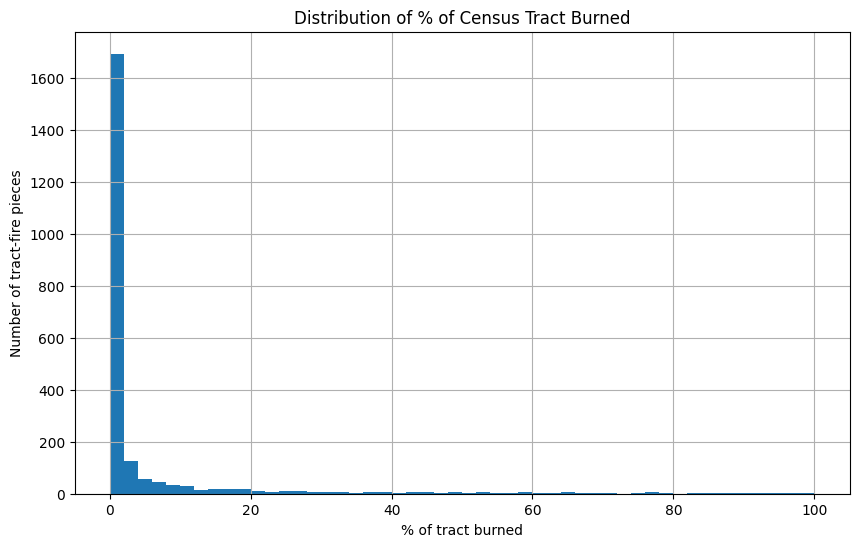

In [56]:

# Plot histogram
plt.figure(figsize=(10, 6))
fires_with_tracts_data["PCT_TRACT_BURNED"].hist(bins=50)

plt.title("Distribution of % of Census Tract Burned")
plt.xlabel("% of tract burned")
plt.ylabel("Number of tract-fire pieces")
plt.grid(True)
plt.show()


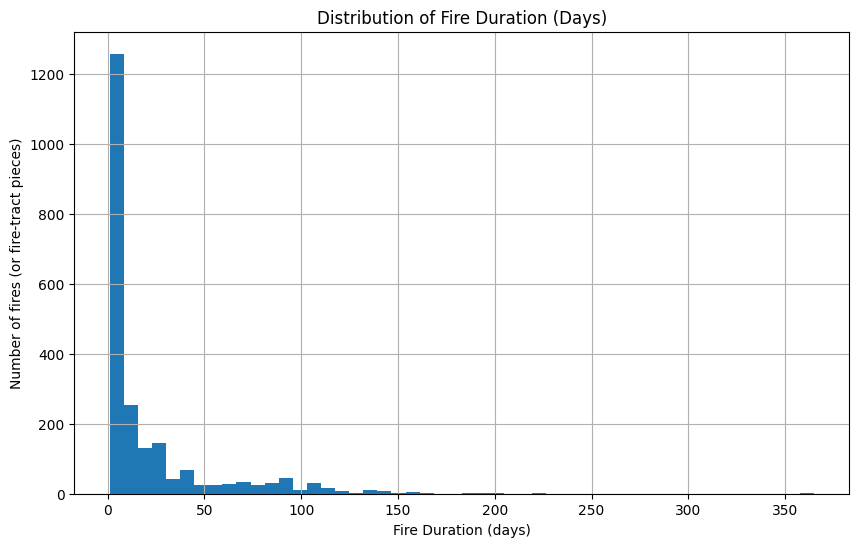

In [57]:

# Plot histogram
plt.figure(figsize=(10, 6))
fires_with_tracts_data["FIRE_DURATION_DAYS"].hist(bins=50)

plt.title("Distribution of Fire Duration (Days)")
plt.xlabel("Fire Duration (days)")
plt.ylabel("Number of fires (or fire-tract pieces)")
plt.grid(True)
plt.show()


In [58]:
# Find thresholds at the 95th percentile
pct_burned_threshold = fires_with_tracts_data['PCT_TRACT_BURNED'].quantile(0.75)
duration_threshold = fires_with_tracts_data['FIRE_DURATION_DAYS'].quantile(0.75)

print(f"75th percentile for % tract burned: {pct_burned_threshold:.2f}%")
print(f"75th percentile for fire duration: {duration_threshold:.2f} days")


75th percentile for % tract burned: 1.61%
75th percentile for fire duration: 23.00 days


In [ ]:
######################################################################
# SAVE FIRE DATA FOR FUTURE USES
######################################################################

# Save as a csv file to reuse

# Save demographic data
final_fire_data["YEAR"] = final_fire_data["YEAR"].astype(int)
final_fire_data["GEO_UNIQUE_ID"] = final_fire_data["GEO_UNIQUE_ID"].astype(str)
final_fire_data.to_csv("final_fire_data.csv", index=False)


# Make sure it has 'GEO_UNIQUE_ID' and 'GEOMETRY_TRACK_CENSUS'




In [60]:
final_census_shapefile = gpd.GeoDataFrame(final_census_shapefile, geometry="geometry", crs="EPSG:3310")

final_census_shapefile.to_file("final_census_shapefile.shp")

/var/folders/_5/g20j99hd5j91r849_d_zgb040000gn/T/ipykernel_99047/3473817015.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_census_shapefile.to_file("final_census_shapefile.shp")
/opt/miniconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'GEO_UNIQUE_ID' to 'GEO_UNIQUE'
  ogr_write(
